# Introduction

In this 1st part of the study, Linux kernel's network reception
facility was studied in a limited environment: UP (1 core) in virtual
machine. The 1st part took a closer look at how the NET_RX soft IRQ
handler is executed and how it fills sockets queues for user-space
application (running syscalls).

In this 2nd part, we will try have a look at interactions betwen the
NET_RX soft IRQ handler and user-space processes in a multi-core
context.

# Description of the test environment

This chapter is nearly identical as the one in the first part. The
only change is the fact that the VM runs 2 cores (instead of only 1).

Here is the new Qemu command line:
```
# qemu-system-x86_64 \
    -enable-kvm -cpu host -smp cores=2 \
    -m 3G \
    -nographic -append "console=ttyS0,9600n8" \
    -netdev tap,id=t0,script=no,downscript=no -device virtio-net,netdev=t0 \
    -kernel bzImage
```

```
# lscpu -e=CPU,CORE,CACHE
CPU CORE L1d:L1i:L2:L3
0   0    0:0:0:0
1   0    0:0:0:0
2   1    1:1:1:0
3   1    1:1:1:0
```

# Some more details on the network configurations

Just like the former chapter, this one did not change compared to the
one in the 1st part; let's just add a detail regarding the multi-core
aspect.

The (emulated) hardware interrupts from the virtio network device are
all routed to core 0:
```
# cat /proc/interrupts | grep virtio
 24:          0          0   PCI-MSI 49152-edge      virtio0-config
 25:    1476198          0   PCI-MSI 49153-edge      virtio0-input.0
 26:          2          0   PCI-MSI 49154-edge      virtio0-output.0
 ```

So, in the VM:

* The virtualized core 0 will execute NET_RX soft IRQ handler each
  time a virtio-net IRQ occurs;
* The virtualized core 1 will execute the user-space application
  netserver which performs "recvfrom" syscalls.

And on the host:

* The hardware core 0 will host:
  * The application netperf which sends UDP packets;
  * Qemu's management thread which transfers the UDP packets from the
    tap interface into the virtio-net device;
  * Qemu's virtualized core 0 (which runs NET_RX soft IRQ handler);
* The hardware core 1 will host:
  * Qemu's virtualized core 1 (which runs netserver process)

Why so many things on the first hardware core ?

* Because it is a nice way to prevent the concurrency issue in
  virtio-net.
* The 3 processes or threads uses the scheduling policy SCHED_OTHER;
  so the resources should be shared fairly and when Qemu's virtualized
  core 0 will be running, we can be sure that neither Qemu's
  management thread nor netperf will introduce some noise.
* With my limited hardware (only 1 laptop machine), this solution is
  the best way (I found) to isolate each virtualized core; the
  virtualized core 0 is not using a whole hardware core but, at least,
  it does not share the HW core resources when the corresponding Qemu
  thread is scheduled.

Why not using hyper-threading ?

* Because we noticed in the former document that sharing core
  resources will have a negative and significant impact on
  performance.

# Description of the benchmark procedure

Same as the 1st part except one detail: the netperf and netserver
processes are configured with core affinity:

* Netperf runs on the hardware core 0 (more precisely the hardware thread 0);
* Netserver runs on the virtualized core 1, which corresponds to the
  hardware core 1 (and more precisely the hardware thread 2).
* Nothing uses the hardware thread 1 and 3;

# Manipulating the 1st benchmark results

Let's have a look at percentile diagrams which looks familiar now:

* net:netif_receive_skb -> net:netif_receive_skb: the NET_RX per
  packet process time;
* raw_syscalls:sys_enter -> raw_syscalls:sys_enter: the per packet
  syscall time.

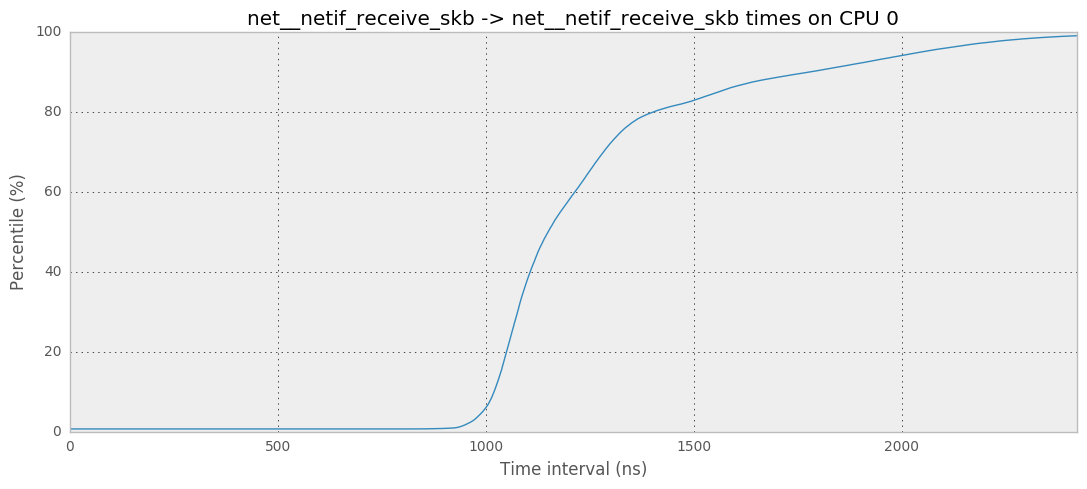

Time interval statistics from net__netif_receive_skb to net__netif_receive_skb :
CPU 0
count   182,131.00
mean      1,284.43
std         609.60
min           0.00
25%       1,064.00
50%       1,151.00
75%       1,326.00
max     102,751.00
Name: duration, dtype: float64


In [7]:
fname = '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms100.csv'
df = pd.read_csv(fname)
df = df.loc[df.cpu == 0].reset_index(drop=True)
lps.print_event_intervals(df, 'net__netif_receive_skb', 'net__netif_receive_skb')
lps.plot_event_intervals(df, 'net__netif_receive_skb', 'net__netif_receive_skb', cpu=0)

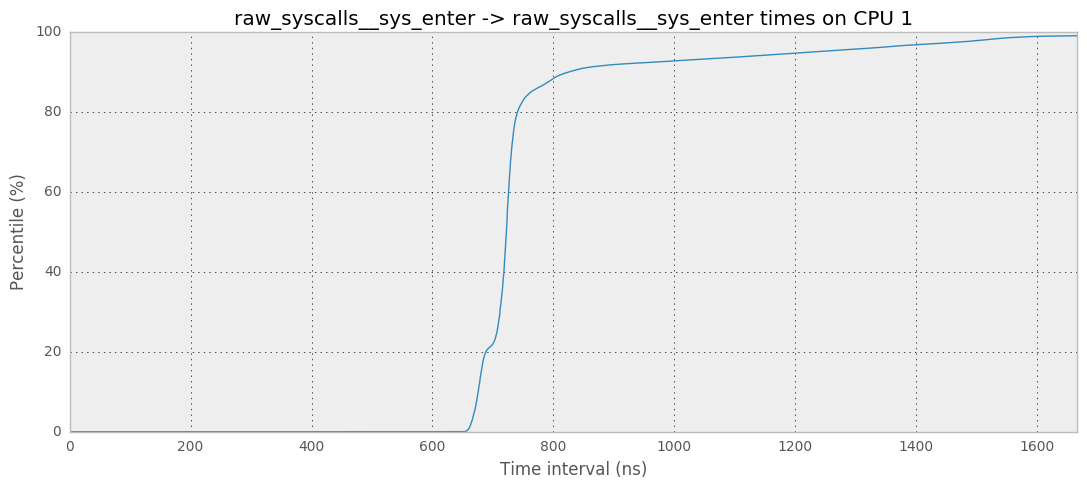

count   3,686,208.00
mean          788.19
std         1,074.04
min             0.00
25%           707.00
50%           723.00
75%           734.00
max       314,299.00
Name: duration, dtype: float64


Time interval statistics from raw_syscalls__sys_enter to raw_syscalls__sys_enter :
CPU 1


In [6]:
fname = '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms100.csv'
df = pd.read_csv(fname)
df = df.loc[df.cpu == 1].reset_index(drop=True)
lps.print_event_intervals(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter')
lps.plot_event_intervals(df, 'raw_syscalls__sys_enter', 'raw_syscalls__sys_enter', cpu=1)

## Interpretation

The goal of the tests above was to find out whether distributing
network reception jobs on 2 cores (1 core for NET_RX + 1 core for
syscall) brings overhead because of concurrency or whatever.

The only interpretation I could give so far is that the difference in
performance (if there is one) is not visual. So let's try to print
more numbers...

## Comparing NET_RX quantile values (1-core-Q10 against 2-cores-Q60)

In [13]:
fname = '/home/alexis/workspace/tmp_public/recv_1core_affinity1_ms100.csv'
df = pd.read_csv(fname)

value = lps.get_event_itv_quantile(df,
				   'net__netif_receive_skb',
				   'net__netif_receive_skb',
				   quantile_value=0.10)

print '1 core NET_RX time:', value, 'ns'

fname = '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms100.csv'
df = pd.read_csv(fname)

value = lps.get_event_itv_quantile(df,
				   'net__netif_receive_skb',
				   'net__netif_receive_skb',
				   quantile_value=0.60)

print '2 cores NET_RX time:', value, 'ns'

2 cores NET_RX time: 1215.0 ns


1 core NET_RX time: 1396.0 ns


## Comparing syscall quantile values

In [12]:
fname = '/home/alexis/workspace/tmp_public/recv_1core_affinity1_ms100.csv'
df = pd.read_csv(fname)

value = lps.get_event_itv_quantile(df,
				   'raw_syscalls__sys_enter',
				   'raw_syscalls__sys_enter',
				   quantile_value=0.60)

print '1 core syscall time:', value, 'ns'

fname = '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms100.csv'
df = pd.read_csv(fname)

value = lps.get_event_itv_quantile(df,
				   'raw_syscalls__sys_enter',
				   'raw_syscalls__sys_enter',
				   quantile_value=0.60, cpu=1)

print '2 cores syscall time:', value, 'ns'

2 cores syscall time: 726.0 ns


1 core syscall time: 719.0 ns


## Interpretation (part 2)

With more accurate results, the differences are not significant enough
to conclude that working with 2 cores brings an overhead because of
concurrency (socket locking for example).

## Temporary conclusion

This benchmark does not prove that executing the NET_RX soft IRQ
handler on 1 core and the user-space reception code on another core is
sub-optimal.

However, the reader should keep in mind that:

* The 2 cores were on the same CPU; what happens if the 2 cores are on
  different CPUs and QPI is used ?
* The message length is 100 bytes; what happens if the message size
  increases?

# Changing UDP packet size

The first parameter we tried to change was: "muli-core instead of
mono-core"; nothing interesting was unveiled; let's try a 2nd
parameter packet size.

The diagrams below will show the evolutions NET_RX times and syscall
times according to UDP packet sizes.

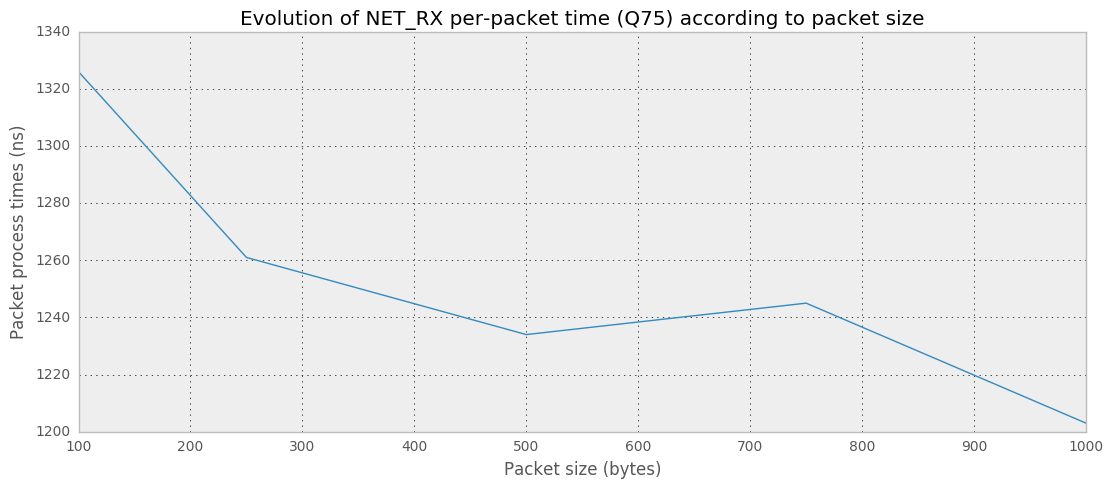

In [15]:
m_sizes = [100, 250, 500, 750, 1000]

fnames = [
    '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms100.csv',
    '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms250.csv',
    '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms500.csv',
    '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms750.csv',
    '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms1000.csv',
]

quantile_values = []

# For each results file, compute the 75-percentile value for time
# intervals between 2 net__netif_receive_skb events
for i, m_size in enumerate(m_sizes):
    fname = fnames[i]
    df = pd.read_csv(fname)
    value = lps.get_event_itv_quantile(df,
				       'net__netif_receive_skb',
				       'net__netif_receive_skb',
				       quantile_value=0.75)
    quantile_values.append(value)

# Create a Pandas Series with the calculated values to...
sr = pd.Series(quantile_values, index=m_sizes)
# ...plot the values
plot = sr.plot()
plot.set_title('Evolution of NET_RX per-packet time (Q75) according to packet size')
plot.set_ylabel('Packet process times (ns)')
plot.set_xlabel('Packet size (bytes)')

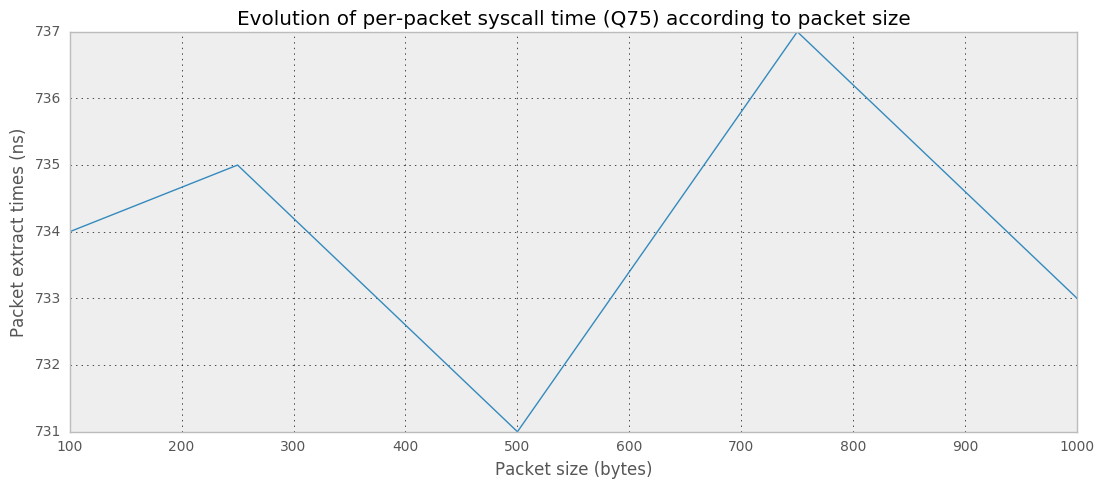

In [3]:
m_sizes = [100, 250, 500, 750, 1000]

fnames = [
    '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms100.csv',
    '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms250.csv',
    '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms500.csv',
    '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms750.csv',
    '/home/alexis/workspace/tmp_public/recv_2cores_affinity1_ms1000.csv',
]

quantile_values = []

# For each results file, compute the 75-percentile value for time
# intervals between 2 net__netif_receive_skb events
for i, m_size in enumerate(m_sizes):
    fname = fnames[i]
    df = pd.read_csv(fname)
    value = lps.get_event_itv_quantile(df,
				       'raw_syscalls__sys_enter',
				       'raw_syscalls__sys_enter',
				       quantile_value=0.75, cpu=1)
    quantile_values.append(value)

# Create a Pandas Series with the calculated values to...
sr = pd.Series(quantile_values, index=m_sizes)
# ...plot the values
plot = sr.plot()
plot.set_title('Evolution of per-packet syscall time (Q75) according to packet size')
plot.set_ylabel('Packet extract times (ns)')
plot.set_xlabel('Packet size (bytes)')

## Interpretation

The packet size seems to have an impact:

* Neither on NET_RX soft IRQ handler times; the per-packet time loses
  100ns when the packet size increases by 900 bytes;
* Nor on the syscall times; the variation is lower than 10ns; this
  point is very surprising considering the fact that the payload is
  copied from kernel to user space.

## Temporary conclusion

Surprisingly, the packet size is not a parameter correlated with the
network reception capacity.

# Conclusion

This second part is a huge failure; it was impossible to explain the
cost of network receptions tasks:

* With 1 core dedicated to the execution of NET_RX soft IRQ handler,
  the maximum throughput of NET_RX reaches 1 Mpkts/s (per-packet time
  is about 1us);
* With basic syscalls (in other words: without using recvmmsg), the
  throughput of packet recovery into user-space is worth more than
  2Mpkts/s (per-packet time = 740ns - 350ns = 390ns);

The tests above shows that executing a syscall which copies data is
nearly as expensive as going through a static tracepoint (tracepoint
cost estimated at 350ns). This is really... weird.

This is why this part of the study is really a failure; either we
miscalculated tracepoint cost or we missed something here. I will need
suitable hardware to perform more serious benchmarks.

# Annex A: Pre-requisite python import code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import linux_perf_stats as lps

pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
lps.configure_plots()

-c:9: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

